# Importing Necessary Libraries

In [65]:
# Libraries from PyTorch
import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader

# Libraries for data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Libraries that makes life easier
from timeit import default_timer as timer
from pathlib import Path
from tqdm.auto import tqdm
import opendatasets as od
import cv2 as cv
from collections import OrderedDict
import os
from torchinfo import summary

# Libraries from Scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# Getting the Dataset

In [14]:
if Path(".\\FER-2013").is_file():
    print("The dataset already exists. Skipping download...")
else:
    print("Downloading the datset...")
    od.download("https://www.kaggle.com/datasets/msambare/fer2013/data")

Skipping, found downloaded files in ".\fer2013" (use force=True to force download)


# Preprocessing and Formatting the Dataset

##### We would be clubbing together the `disgust` and `surprise` emotion directories into a single emotion directory `shock` because of the difference in the numbers of files in those directories

##### Also we would be reducing the number of files in the `train dataset` so that the model doesn't gets baised into predicting a single emotion
##### However, there would be no reduction in the number of files in the `test dataset` only the clubbing of the directories will take place

###### Execute the next line of code if you are accessing this jupyter file for the first time

In [15]:
# %run dataset_formatting.py

## Curating a dataset from the FER2013 dataset

#### `Step-1` :- we would be converting the images into sketches so that the features becomes obvious for CNN for feature extraction

In [16]:
train_arr = np.arange(0,2304,1)
train_arr = np.append(train_arr, [7])
train_arr.shape

(2305,)

In [17]:
test_arr = np.arange(0,2304,1)
test_arr = np.append(test_arr, [7])
test_arr.shape

(2305,)

In [18]:
def convert_to_sketch(state,arr):
    for emotion in range(0,6):
        emotion_dir = f"./fer2013/{state}/{emotion}"
        for count,file in enumerate(os.listdir(emotion_dir)):
            src = f"{emotion_dir}/{file}"
            img = cv.imread(src)
            gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            inverted = 255 - gray
            blurred = cv.GaussianBlur(inverted,(21,21),0)
            drawing = cv.divide(gray,255 - blurred, scale=256)
            flat = drawing.flatten()
            if state=='train':
                flat2 = np.append(flat,[emotion])
                arr = np.vstack((arr,flat2))
            elif state=='test':
                flat3 = np.append(flat,[emotion])
                arr = np.vstack((arr,flat3))
    return arr

In [19]:
states = ['train','test']
for state in states:
    train_arr = convert_to_sketch(state,train_arr)
    test_arr = convert_to_sketch(state,test_arr)

In [21]:
train_arr.shape

(28779, 2305)

In [22]:
test_arr.shape

(28779, 2305)

In [23]:
new_arr_train = np.delete(train_arr,0,axis=0)
new_arr_train

array([[255, 255, 255, ..., 205, 205,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 255, ..., 233, 225,   0],
       ...,
       [255, 255, 255, ..., 200, 187,   5],
       [226, 222, 194, ..., 255, 255,   5],
       [255, 255, 255, ..., 184, 102,   5]])

In [24]:
new_arr_test = np.delete(test_arr,0,axis=0)
new_arr_test

array([[255, 255, 255, ..., 205, 205,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 255, ..., 233, 225,   0],
       ...,
       [255, 255, 255, ..., 200, 187,   5],
       [226, 222, 194, ..., 255, 255,   5],
       [255, 255, 255, ..., 184, 102,   5]])

### Visualizing the dataset using t-SNE

In [25]:
x = new_arr_train[:,:-1]
y = new_arr_train[:,-1]

In [26]:
len(x),len(y)

(28778, 28778)

In [27]:
tsvd = TruncatedSVD(n_components=50).fit_transform(x)
tsne_res = TSNE(n_components=2, n_jobs = -1, random_state = 42).fit_transform(tsvd)

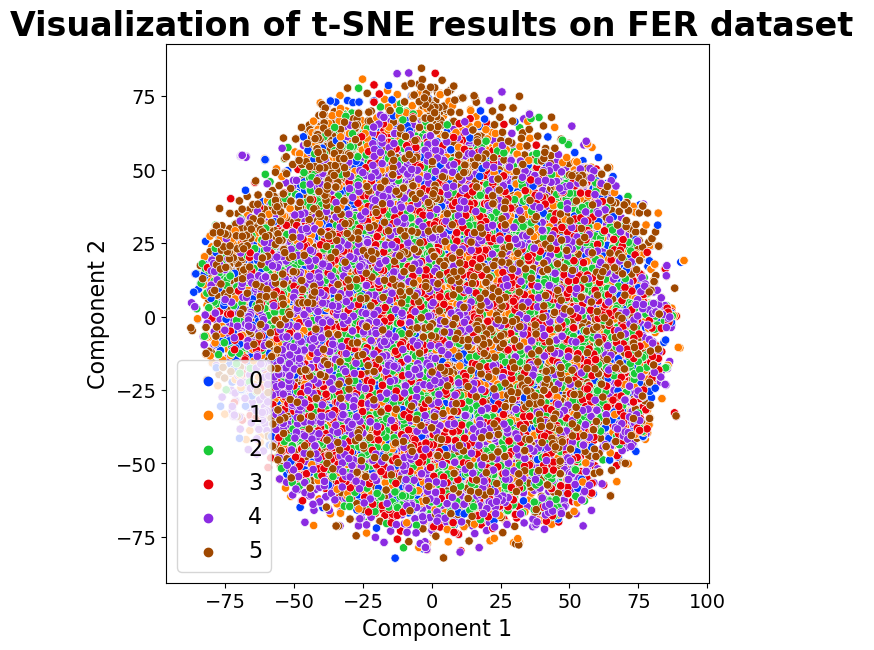

In [28]:
plt.figure(figsize=(7, 7))
plt.title("Visualization of t-SNE results on FER dataset ", fontsize=24, weight='bold')
sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=y, palette="bright", legend="full")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16);

### Fitting the emotions into clusters

In [29]:
cluster = ['c1','c2','c3','c4','c5','c6']
emotions = ['angry','fear','happy','neutral','sad','shock']

In [30]:
def making_clusters(x,y,emotion_no):
    emotion_c1 = 0
    emotion_c2 = 0
    emotion_c3 = 0
    emotion_c4 = 0
    emotion_c5 = 0
    emotion_c6 = 0
    emotion_C1 = []
    emotion_C2 = []
    emotion_C3 = []
    emotion_C4 = []
    emotion_C5 = []
    emotion_C6 = []
    for i in range(0,28778):
        if y[i]==emotion_no:
            y1 = tsne_res[i:i+1, 1]
            x1 = tsne_res[i:i+1, 0]
            if ((y1 - (1.7320*x1)) <= 0) and ((y1 >= 0)):
                emotion_c1 = 1 + emotion_c1
                emotion_C1.append(i)
            elif ((y1 - (1.7320*x1))>=0) and ((y1 + (1.7320*x1))>=0):
                emotion_c2 = 1 + emotion_c2
                emotion_C2.append(i)
            elif ((y1 + (1.7320*x1))<=0) and ((y1 >= 0)):
                emotion_c3 = 1 + emotion_c3
                emotion_C3.append(i)
            elif ((y1 - (1.7320*x1)) >= 0) and ((y1 <= 0)):
                emotion_c4 = 1 + emotion_c4
                emotion_C4.append(i)
            elif ((y1 - (1.7320*x1)) <= 0) and ((y1 + (1.7320*x1))<=0):
                emotion_c5 = 1 + emotion_c5
                emotion_C5.append(i)
            elif  ((y1 + (1.7320*x1))>=0) and ((y1 <= 0)):
                emotion_c6 = 1 + emotion_c6
                emotion_C6.append(i)
    emotion_c = [emotion_c1,emotion_c2,emotion_c3,emotion_c4,emotion_c5,emotion_c6]
    emotion_C = [emotion_C1,emotion_C2,emotion_C3,emotion_C4,emotion_C5,emotion_C6]
    
    return emotion_c,emotion_C

In [35]:
angry_c , angry_C = making_clusters(x,y,0)
fear_c , fear_C = making_clusters(x,y,1)
happy_c , happy_C = making_clusters(x,y,2)
neutral_c , neutral_C = making_clusters(x,y,3)
sad_c , sad_C = making_clusters(x,y,4)
shock_c , shock_C = making_clusters(x,y,5)

### Visualizing the clusters obtained

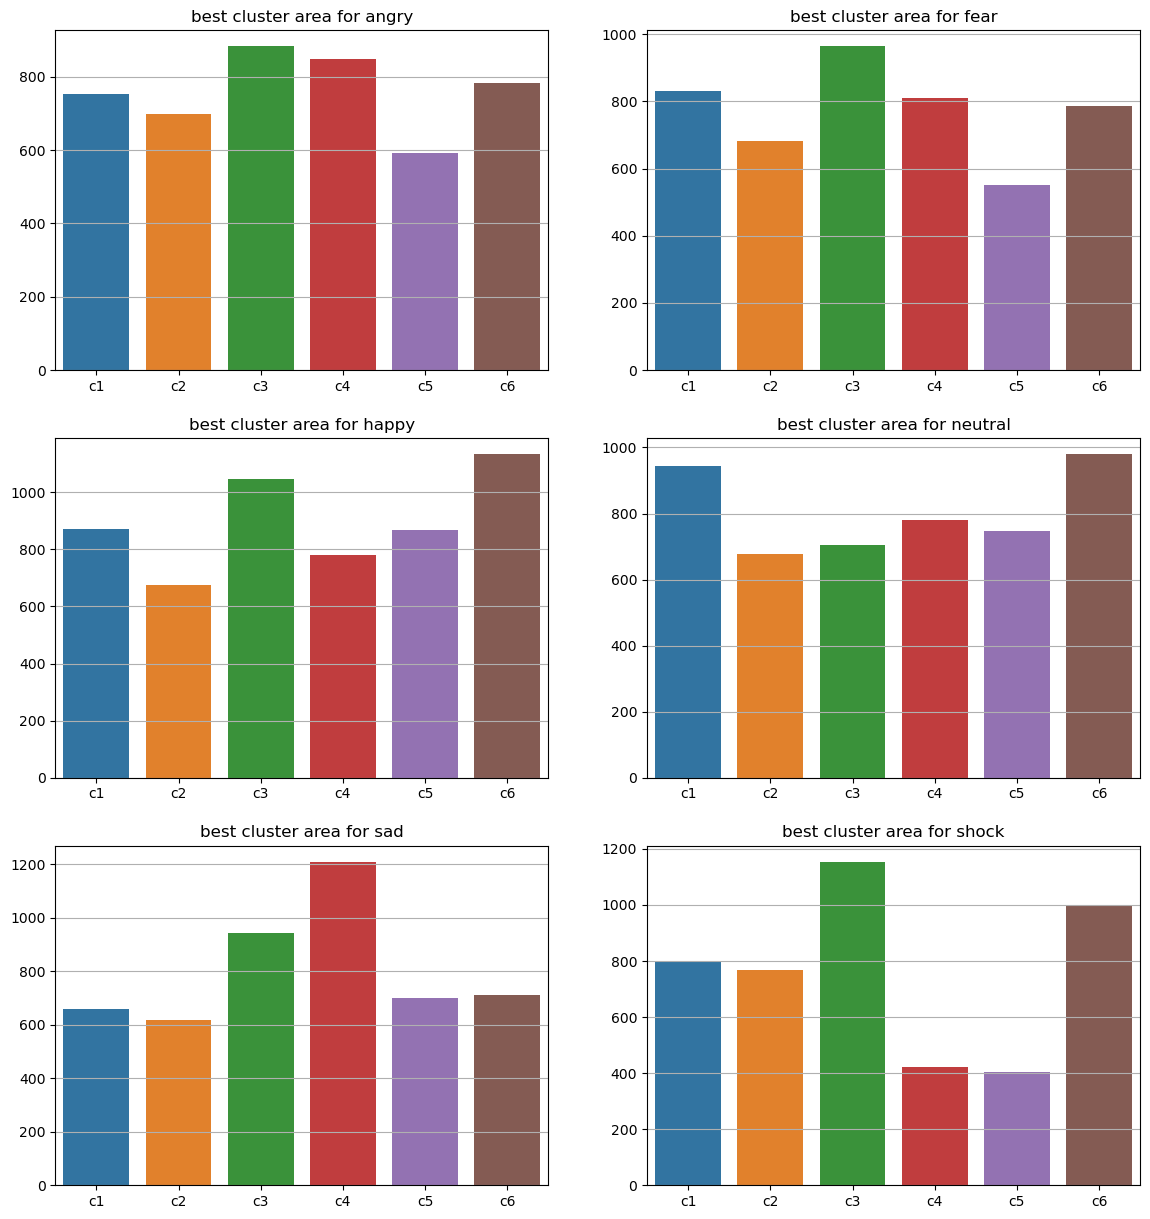

In [36]:
plt.figure(figsize=(14,15))
plt.subplot(321)
plt.grid()
sns.barplot(x=cluster,y=angry_c)
plt.title(label="best cluster area for angry")
plt.subplot(322)
plt.grid()
sns.barplot(x=cluster,y=fear_c)
plt.title(label="best cluster area for fear")
plt.subplot(323)
plt.grid()
sns.barplot(x=cluster,y=happy_c)
plt.title(label="best cluster area for happy")
plt.subplot(324)
plt.grid()
sns.barplot(x=cluster,y=neutral_c)
plt.title(label="best cluster area for neutral")
plt.subplot(325)
plt.grid()
sns.barplot(x=cluster,y=sad_c)
plt.title(label="best cluster area for sad")
plt.subplot(326)
plt.grid()
sns.barplot(x=cluster,y=shock_c)
plt.title(label="best cluster area for shock")
plt.show()

### Creating an array of the most suitable clusters

In [ ]:
suitable_index = [5,0,4,3,2,1]

In [37]:
listd = angry_C[0] + angry_C[1] + angry_C[2] + angry_C[3] + angry_C[4] + fear_C[3] + fear_C[1] + fear_C[2] + fear_C[4] + fear_C[5] + happy_C[0] + happy_C[1] + happy_C[3] + happy_C[2] + happy_C[5] + neutral_C[1] + neutral_C[2] + neutral_C[0] + neutral_C[4] + neutral_C[5] + sad_C[0] + sad_C[1] + sad_C[3] + sad_C[4] + sad_C[5] + shock_C[0] + shock_C[4] + shock_C[2] + shock_C[3] + shock_C[5]
len(listd)

23808

In [39]:
new_arr1 = np.delete(new_arr_train,listd,axis=0)
new_arr1 , new_arr1.shape

(array([[255, 255, 255, ..., 205, 205,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [255, 255, 255, ..., 188,  76,   0],
        ...,
        [255, 255,  79, ..., 233, 242,   5],
        [226, 222, 194, ..., 255, 255,   5],
        [255, 255, 255, ..., 184, 102,   5]]),
 (4970, 2305))

### Visualizing the newly formatted dataset using t-SNE

In [40]:
X1 = new_arr1[:,:-1]
Y1 = new_arr1[:,-1]

In [41]:
tsvd1 = TruncatedSVD(n_components=50).fit_transform(X1)
tsne_res1 = TSNE(n_components=2, n_jobs = -1, random_state = 42).fit_transform(tsvd1)

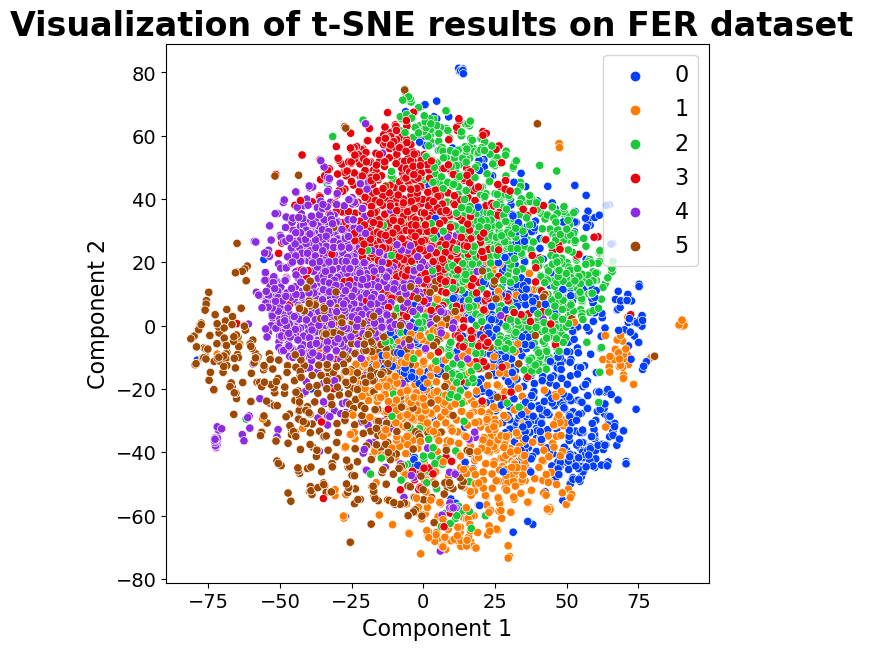

In [42]:
plt.figure(figsize=(7, 7))
plt.title("Visualization of t-SNE results on FER dataset ", fontsize=24, weight='bold')
sns.scatterplot(x=tsne_res1[:, 0], y=tsne_res1[:, 1], hue=Y1, palette="bright", legend="full")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16);

### Creating a DataFrame of the newly formatted data

In [43]:
column = []
for i in range(1,49):
    for j in range(1,49):
        column.append(f"{i}x{j}")

column.append("label")

In [44]:
df_train = pd.DataFrame(new_arr1, columns =column) 
print("\nPandas DataFrame: ") 
df_train


Pandas DataFrame: 


,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,255,255,255,156,213,255,255,128,75,167,...,255,255,255,255,255,255,124,205,205,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,255,255,255,255,255,255,255,255,255,255,...,111,147,176,203,251,246,234,188,76,0
3,0,0,0,0,0,0,0,0,8,3,...,255,255,255,255,255,255,99,25,35,0
4,230,255,251,235,230,255,205,255,211,255,...,148,77,82,118,102,109,104,114,154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,186,197,186,191,215,255,255,255,237,254,...,157,255,255,255,255,255,255,255,255,5
4966,146,169,187,209,232,241,237,231,228,237,...,219,229,255,255,255,255,255,255,255,5
4967,255,255,79,255,255,255,255,255,255,165,...,197,218,224,225,219,221,229,233,242,5
4968,226,222,194,223,243,235,248,241,143,116,...,255,255,255,255,255,255,255,255,255,5


In [46]:
df_test = pd.DataFrame(test_arr,columns=column)
print("\nPandas DataFrame: ")
df_test


Pandas DataFrame: 


,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,7
1,255,255,255,156,213,255,255,128,75,167,...,255,255,255,255,255,255,124,205,205,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,255,255,255,255,255,255,255,255,211,...,210,206,198,202,215,227,231,233,225,0
4,255,255,255,255,255,255,255,255,255,255,...,255,253,243,255,254,242,242,239,233,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28774,146,169,187,209,232,241,237,231,228,237,...,219,229,255,255,255,255,255,255,255,5
28775,255,255,79,255,255,255,255,255,255,165,...,197,218,224,225,219,221,229,233,242,5
28776,255,255,255,250,255,255,255,255,248,238,...,255,255,255,255,255,255,226,200,187,5
28777,226,222,194,223,243,235,248,241,143,116,...,255,255,255,255,255,255,255,255,255,5


### Saving the curated dataset

In [48]:
save_dir = './FER_curated_dataset/'
os.makedirs(save_dir,exist_ok=True)
df_train.to_csv(save_dir + 'train.csv')
df_test.to_csv(save_dir + 'test.csv')

# Creating and Training the Model

In [109]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

### Reading the dataset using Pandas

In [49]:
# Load and preprocess data
df_train = pd.read_csv("./FER_curated_dataset/train.csv")
df_train

,Unnamed: 0,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,0,255,255,255,156,213,255,255,128,75,...,255,255,255,255,255,255,124,205,205,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,255,255,255,255,255,255,255,255,255,...,111,147,176,203,251,246,234,188,76,0
3,3,0,0,0,0,0,0,0,0,8,...,255,255,255,255,255,255,99,25,35,0
4,4,230,255,251,235,230,255,205,255,211,...,148,77,82,118,102,109,104,114,154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,4965,186,197,186,191,215,255,255,255,237,...,157,255,255,255,255,255,255,255,255,5
4966,4966,146,169,187,209,232,241,237,231,228,...,219,229,255,255,255,255,255,255,255,5
4967,4967,255,255,79,255,255,255,255,255,255,...,197,218,224,225,219,221,229,233,242,5
4968,4968,226,222,194,223,243,235,248,241,143,...,255,255,255,255,255,255,255,255,255,5


In [51]:
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_train

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,255,255,255,156,213,255,255,128,75,167,...,255,255,255,255,255,255,124,205,205,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,255,255,255,255,255,255,255,255,255,255,...,111,147,176,203,251,246,234,188,76,0
3,0,0,0,0,0,0,0,0,8,3,...,255,255,255,255,255,255,99,25,35,0
4,230,255,251,235,230,255,205,255,211,255,...,148,77,82,118,102,109,104,114,154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,186,197,186,191,215,255,255,255,237,254,...,157,255,255,255,255,255,255,255,255,5
4966,146,169,187,209,232,241,237,231,228,237,...,219,229,255,255,255,255,255,255,255,5
4967,255,255,79,255,255,255,255,255,255,165,...,197,218,224,225,219,221,229,233,242,5
4968,226,222,194,223,243,235,248,241,143,116,...,255,255,255,255,255,255,255,255,255,5


In [52]:
df_test = pd.read_csv("./FER_curated_dataset/test.csv")
df_test

,Unnamed: 0,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,0,0,1,2,3,4,5,6,7,8,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,7
1,1,255,255,255,156,213,255,255,128,75,...,255,255,255,255,255,255,124,205,205,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,255,255,255,255,255,255,255,255,255,...,210,206,198,202,215,227,231,233,225,0
4,4,255,255,255,255,255,255,255,255,255,...,255,253,243,255,254,242,242,239,233,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28774,28774,146,169,187,209,232,241,237,231,228,...,219,229,255,255,255,255,255,255,255,5
28775,28775,255,255,79,255,255,255,255,255,255,...,197,218,224,225,219,221,229,233,242,5
28776,28776,255,255,255,250,255,255,255,255,248,...,255,255,255,255,255,255,226,200,187,5
28777,28777,226,222,194,223,243,235,248,241,143,...,255,255,255,255,255,255,255,255,255,5


In [54]:
df_test = df_test.drop(['Unnamed: 0'],axis=1)
df_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,7
1,255,255,255,156,213,255,255,128,75,167,...,255,255,255,255,255,255,124,205,205,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,255,255,255,255,255,255,255,255,211,...,210,206,198,202,215,227,231,233,225,0
4,255,255,255,255,255,255,255,255,255,255,...,255,253,243,255,254,242,242,239,233,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28774,146,169,187,209,232,241,237,231,228,237,...,219,229,255,255,255,255,255,255,255,5
28775,255,255,79,255,255,255,255,255,255,165,...,197,218,224,225,219,221,229,233,242,5
28776,255,255,255,250,255,255,255,255,248,238,...,255,255,255,255,255,255,226,200,187,5
28777,226,222,194,223,243,235,248,241,143,116,...,255,255,255,255,255,255,255,255,255,5


### Accessing the images and the labels

In [56]:
# From train.csv
x_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values

# From test.csv
x_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:,-1].values

In [57]:
# Verify feature sizes
print("Feature shape before reshaping:", x_train.shape)

# Ensure the correct feature size
if x_train.shape[1] != 48 * 48:
    raise ValueError(f"Each feature should have 2304 elements, but got {x.shape[1]}")

Feature shape before reshaping: (4970, 2304)


### Defining a Custom Dataset

In [58]:
class class_Dataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features.astype(np.float32)  # Ensure features are float32
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        # Reshape the feature into the original image shape (48, 48)
        feature = feature.reshape(48, 48)
        
        if self.transform:
            feature = self.transform(feature)
        
        return feature, label

### Applying transformations to the dataset

In [59]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors and scale to [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

# Create instances of the custom dataset
train_dataset = class_Dataset(x_train, y_train, transform=transform)
test_dataset = class_Dataset(x_test, y_test, transform=transform)

### Creating DataLoaders

In [60]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x298ad048810>,
 <torch.utils.data.dataloader.DataLoader at 0x298b6c06290>)

### Setting-up device agnostic code

In [92]:
# device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

### Building the Model

In [94]:
class DetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,padding=1)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,padding=1)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,6)
        )
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        
        return x
    
model = DetectionModel().to(device)
model

DetectionModel(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10

In [95]:
summary(model,input_shape=(1,1,48,48))

Layer (type:depth-idx)                   Param #
DetectionModel                           --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       18,496
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
├─Sequential: 1-4                        --
│    └─Flatten: 2-15                     --
│    └─Linear: 2-16                      9,438,

### Setting-up Loss Function and optimizer

In [96]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.00001)

### Code for stopping the training loop early

In [97]:
# Early stopping class definition (if not already defined)
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pth')
        if self.verbose:
            print(f'Validation loss decreased. Saving model ...')

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

### Making the Training Loop

In [98]:
# Training loop
num_epochs = 50
trainloss, testloss = [], []
trainaccuracy, testaccuracy = [], []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    
    for train_images, train_labels in train_dataloader:
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        optimizer.zero_grad()
        outputs = model(train_images)
        train_loss = loss_fn(outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        _, train_pred = torch.max(outputs.data, dim=-1)
        correct_train += (train_pred == train_labels).sum().item()
        running_train_loss += train_loss.item()
    
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / len(train_dataloader.dataset)
    
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    
    with torch.no_grad():
        for test_images, test_labels in test_dataloader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            test_outputs = model(test_images)
            test_loss = loss_fn(test_outputs, test_labels)
            _, test_pred = torch.max(test_outputs.data, 1)
            correct_test += (test_pred == test_labels).sum().item()
            running_test_loss += test_loss.item()
    
    avg_test_loss = running_test_loss / len(test_dataloader)
    test_accuracy = 100 * correct_test / len(test_dataloader.dataset)
    
    trainloss.append(avg_train_loss)
    testloss.append(avg_test_loss)
    trainaccuracy.append(train_accuracy)
    testaccuracy.append(test_accuracy)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%')
    
    early_stopping(avg_test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pth'))


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
